# Data Science Example

## 0 - Setting up the notebook

In [2]:
import json
import calendar
import random
from datetime import date, timedelta
import faker
import numpy as np
from pandas import DataFrame
from delorean import parse
import pandas as pd
import matplotlib.pyplot as plt
# make the graphs nicer
plt.show(block=True)
import pylab
pylab.rcParams.update({'font.family':'serif'})
% matplotlib inline


ModuleNotFoundError: No module named 'beakerx'

## 1 - Preparing the Data

In [2]:
# create the faker to populate the data
fake = faker.Faker()

In [3]:
usernames = set()
usernames_no = 1000

# populate the set with 1000 unique usernames
while len(usernames) < usernames_no:
    usernames.add(fake.user_name())

In [4]:
# https://docs.python.org/3/library/random.html#random.random
# Just for comparison reasons I use random seed 
random.seed(42)

def get_random_name_and_gender():
    skew = .6  # 60% of users will be female
    male = random.random() > skew
    if male:
        return fake.name_male(), 'M'
    else:
        return fake.name_female(), 'F'

# for each username, create a complete user profile
# simulate user data coming from an API. It is a list
# of JSON strings (users).
def get_users(usernames):
    users = []
    for username in usernames:
        name, gender = get_random_name_and_gender()
        user = {
            'username': username,
            'name': name,
            'gender': gender,
            'email': fake.email(),
            'age': fake.random_int(min=18, max=90),
            'address': fake.address(),
        }
        users.append(json.dumps(user))
    return users
# https://stackoverflow.com/questions/32911336/what-is-the-difference-between-json-dumps-and-json-load
users = get_users(usernames)
users[:3]

['{"username": "leejustin", "name": "John Archer", "gender": "M", "email": "ariana67@garcia-smith.biz", "age": 34, "address": "258 Lauren Center Suite 830\\nPort Hollyview, UT 34914-2422"}',
 '{"username": "feliciaguerrero", "name": "Amanda Shields", "gender": "F", "email": "palmerkayla@clarke.com", "age": 55, "address": "45868 Anderson Plains\\nWest Rachel, LA 57835"}',
 '{"username": "rodrigueztracey", "name": "Mary Bray", "gender": "F", "email": "eshields@yahoo.com", "age": 47, "address": "Unit 1282 Box 5464\\nDPO AE 44958-7587"}']

In [5]:
# campaign name format:
# InternalType_StartDate_EndDate_TargetAge_TargetGender_Currency
def get_type():
    # just some gibberish internal codes
    types = ['AKX', 'BYU', 'GRZ', 'KTR']
    return random.choice(types)
# choice just picks randomly from the selected list of items

def get_start_end_dates():
    duration = random.randint(1, 2 * 365)
    offset = random.randint(-365, 365)
    start = date.today() - timedelta(days=offset)
    end = start + timedelta(days=duration)
    
    def _format_date(date_):
        return date_.strftime("%Y%m%d")
    
    return _format_date(start), _format_date(end)

def get_age():
    age = random.randint(20, 45)
    age -= age % 5
    diff = random.randint(5, 25)
    diff -= diff % 5
    return '{}-{}'.format(age, age + diff)

def get_gender():
    return random.choice(('M', 'F', 'B'))

def get_currency():
    return random.choice(('GBP', 'EUR', 'USD'))

def get_campaign_name():
    separator = '_' # <-- link all the variables using underscore
    type_ = get_type()
    start_end = separator.join(get_start_end_dates())
    age = get_age()
    gender = get_gender()
    currency = get_currency()
    return separator.join(
        (type_, start_end, age, gender, currency))

In [6]:
# campaign data:
# name, budget, spent, clicks, impressions
# The main purpose of the different kinds of distributions is to show
# options and capabilities of the random module
def get_campaign_data():
    name = get_campaign_name()
    budget = random.randint(10**3, 10**6)
    spent = random.randint(10**2, budget)    
    clicks = int(random.triangular(10**2, 10**5, 0.2 * 10**5))    
    impressions = int(random.gauss(0.5 * 10**6, 2))
    return {
        'cmp_name': name,
        'cmp_bgt': budget,
        'cmp_spent': spent,
        'cmp_clicks': clicks,
        'cmp_impr': impressions
    }

In [7]:
# assemble the logic to get the final version of the rough data
# data will be a list of dictionaries. Each dictionary will follow
# this structure:
# {'user': user_json, 'campaigns': [c1, c2, ...]}
# where user_json is the JSON string version of a user data dict
# and c1, c2, ... are campaign dicts as returned by
# get_campaign_data

def get_data(users):
    data = []
    for user in users:
        campaigns = [get_campaign_data()
                     for _ in range(random.randint(2, 8))]
        data.append({'user': user, 'campaigns': campaigns})
    return data

## 2 - Cleaning the data

In [8]:
# fetch simulated rough data
rough_data = get_data(users)

rough_data[:2]  # let's take a peek

[{'campaigns': [{'cmp_bgt': 200028,
    'cmp_clicks': 79813,
    'cmp_impr': 500000,
    'cmp_name': 'GRZ_20170529_20181208_30-35_F_EUR',
    'cmp_spent': 32123},
   {'cmp_bgt': 256400,
    'cmp_clicks': 58738,
    'cmp_impr': 499999,
    'cmp_name': 'BYU_20170604_20190324_35-40_M_EUR',
    'cmp_spent': 33110}],
  'user': '{"username": "leejustin", "name": "John Archer", "gender": "M", "email": "ariana67@garcia-smith.biz", "age": 34, "address": "258 Lauren Center Suite 830\\nPort Hollyview, UT 34914-2422"}'},
 {'campaigns': [{'cmp_bgt': 812984,
    'cmp_clicks': 58900,
    'cmp_impr': 499998,
    'cmp_name': 'AKX_20180820_20200310_35-45_M_EUR',
    'cmp_spent': 154821},
   {'cmp_bgt': 909536,
    'cmp_clicks': 16287,
    'cmp_impr': 499999,
    'cmp_name': 'BYU_20170913_20180125_25-35_M_USD',
    'cmp_spent': 27132},
   {'cmp_bgt': 55944,
    'cmp_clicks': 54566,
    'cmp_impr': 499996,
    'cmp_name': 'GRZ_20170726_20180327_30-35_M_EUR',
    'cmp_spent': 8407}],
  'user': '{"username"

In [9]:
# Let's start from having a different version of the data
# I want a list whose items will be dicts. Each dict is 
# the original campaign dict plus the user JSON

data = []
for datum in rough_data:
    for campaign in datum['campaigns']:
        campaign.update({'user': datum['user']})
        data.append(campaign)
data[:2]  # let's take another peek

[{'cmp_bgt': 200028,
  'cmp_clicks': 79813,
  'cmp_impr': 500000,
  'cmp_name': 'GRZ_20170529_20181208_30-35_F_EUR',
  'cmp_spent': 32123,
  'user': '{"username": "leejustin", "name": "John Archer", "gender": "M", "email": "ariana67@garcia-smith.biz", "age": 34, "address": "258 Lauren Center Suite 830\\nPort Hollyview, UT 34914-2422"}'},
 {'cmp_bgt': 256400,
  'cmp_clicks': 58738,
  'cmp_impr': 499999,
  'cmp_name': 'BYU_20170604_20190324_35-40_M_EUR',
  'cmp_spent': 33110,
  'user': '{"username": "leejustin", "name": "John Archer", "gender": "M", "email": "ariana67@garcia-smith.biz", "age": 34, "address": "258 Lauren Center Suite 830\\nPort Hollyview, UT 34914-2422"}'}]

### Creating the DataFrame

In [10]:
# data is good enough for creating an initial DataFrame
df = DataFrame(data)

# let's take a peek at the first 5 rows, to make sure
# nothing weird has happened
df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,200028,79813,500000,GRZ_20170529_20181208_30-35_F_EUR,32123,"{""username"": ""leejustin"", ""name"": ""John Archer..."
1,256400,58738,499999,BYU_20170604_20190324_35-40_M_EUR,33110,"{""username"": ""leejustin"", ""name"": ""John Archer..."
2,812984,58900,499998,AKX_20180820_20200310_35-45_M_EUR,154821,"{""username"": ""feliciaguerrero"", ""name"": ""Amand..."
3,909536,16287,499999,BYU_20170913_20180125_25-35_M_USD,27132,"{""username"": ""feliciaguerrero"", ""name"": ""Amand..."
4,55944,54566,499996,GRZ_20170726_20180327_30-35_M_EUR,8407,"{""username"": ""feliciaguerrero"", ""name"": ""Amand..."


In [11]:
# OK! DataFrame is alive and well!
# let's get a sense of how many rows there are and what is
# their structure.
df.count()

cmp_bgt       5044
cmp_clicks    5044
cmp_impr      5044
cmp_name      5044
cmp_spent     5044
user          5044
dtype: int64

In [12]:
df.describe()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_spent
count,5044.000000,5044.000000,5044.000000,5044.000000
mean,500858.238898,40321.405432,499999.511301,252079.196669
std,288360.721791,21663.484842,2.014736,223597.062969
min,1037.000000,800.000000,499992.000000,113.000000
25%,247293.500000,22780.750000,499998.000000,66591.250000
50%,501445.500000,36759.500000,500000.000000,185959.500000
75%,752236.250000,55465.250000,500001.000000,392838.750000
max,999920.000000,99567.000000,500006.000000,991837.000000


In [13]:
# let's see which are the top and bottom 3 campaigns according
# to budget (regardless of the currency)
df.sort_values(by=['cmp_bgt'], ascending=False).head(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
956,999920,49719,499999,GRZ_20171121_20190205_25-30_M_GBP,795566,"{""username"": ""kennethbrown"", ""name"": ""Julie Me..."
780,999912,41254,500001,GRZ_20190225_20201019_35-40_M_GBP,346392,"{""username"": ""cynthia94"", ""name"": ""Lorraine Cu..."
728,999886,82425,499999,BYU_20180303_20180727_35-45_M_USD,444436,"{""username"": ""charlesfoster"", ""name"": ""Jennife..."


In [14]:
df.sort_values(by=['cmp_bgt'], ascending=False).tail(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
2072,1662,9654,499998,BYU_20181019_20181103_30-45_M_GBP,535,"{""username"": ""gregory25"", ""name"": ""Michelle Po..."
423,1205,88329,500002,KTR_20180703_20200118_30-45_F_EUR,170,"{""username"": ""shelby92"", ""name"": ""Chad Houston..."
1038,1037,43728,500000,AKX_20170620_20181030_40-50_M_GBP,256,"{""username"": ""edward63"", ""name"": ""Marcia Ander..."


## 3 - Manipulating the DataFrame

In [15]:
# first, let's explode cmp_name into its components
# and get a separate DataFrame for those

def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split('_')
    start = parse(start).date
    end = parse(end).date
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name)

In [16]:
sample = campaign_data[:4]
sample

0    (GRZ, 2017-05-29, 2018-08-12, 30-35, F, EUR)
1    (BYU, 2017-04-06, 2019-03-24, 35-40, M, EUR)
2    (AKX, 2018-08-20, 2020-10-03, 35-45, M, EUR)
3    (BYU, 2017-09-13, 2018-01-25, 25-35, M, USD)
Name: cmp_name, dtype: object

In [17]:
campaign_cols = [
    'Type', 'Start', 'End', 'Age', 'Gender', 'Currency']

# the .tolist() step is important to shape the data in a way that pandas can 
# easily recongnize 

campaign_df = DataFrame(
    campaign_data.tolist(), columns=campaign_cols, index=df.index) # <-- CHECK
# Very important to use the index of the main dataframe
# this will allow to easily join both dataframes
campaign_df.head(3)

,Type,Start,End,Age,Gender,Currency
0,GRZ,2017-05-29,2018-08-12,30-35,F,EUR
1,BYU,2017-04-06,2019-03-24,35-40,M,EUR
2,AKX,2018-08-20,2020-10-03,35-45,M,EUR


In [18]:
# let's join the two dataframes
df = df.join(campaign_df)

In [19]:
# and take a peek: good! We didn't screw up!
df[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Age,Gender,Currency
0,GRZ_20170529_20181208_30-35_F_EUR,GRZ,2017-05-29,2018-08-12,30-35,F,EUR
1,BYU_20170604_20190324_35-40_M_EUR,BYU,2017-04-06,2019-03-24,35-40,M,EUR
2,AKX_20180820_20200310_35-45_M_EUR,AKX,2018-08-20,2020-10-03,35-45,M,EUR


In [20]:
# now let's do the same for the JSON user object

def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
    ]

user_data = df['user'].apply(unpack_user_json)
user_cols = [
    'username', 'email', 'name', 'gender', 'age', 'address']
user_df = DataFrame(
    user_data.tolist(), columns=user_cols, index=df.index)

In [21]:
# let's join the two dataframes
df = df.join(user_df)

In [22]:
# and take a peek: good! Also this time we didn't screw up!
df[['user'] + user_cols].head(2)

,user,username,email,name,gender,age,address
0,"{""username"": ""leejustin"", ""name"": ""John Archer...",leejustin,ariana67@garcia-smith.biz,John Archer,M,34,"258 Lauren Center Suite 830\nPort Hollyview, U..."
1,"{""username"": ""leejustin"", ""name"": ""John Archer...",leejustin,ariana67@garcia-smith.biz,John Archer,M,34,"258 Lauren Center Suite 830\nPort Hollyview, U..."


In [23]:
# now we have the DataFrame completely expanded, so it's
# time to play with it. First, let's fix those ugly column names
better_columns = [
    'Budget', 'Clicks', 'Impressions',
    'cmp_name', 'Spent', 'user',
    'Type', 'Start', 'End',
    'Target Age', 'Target Gender', 'Currency',
    'Username', 'Email', 'Name',
    'Gender', 'Age', 'Address',
]
df.columns = better_columns

In [24]:
# let's add three other columns

def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df['Impressions']
    
calculate_extra_columns(df)

In [25]:
# let's take a peek
df[['Spent', 'Clicks', 'Impressions',
    'CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,32123,79813,500000,0.159626,0.402478,0.064246
1,33110,58738,499999,0.117476,0.563690,0.066220
2,154821,58900,499998,0.117800,2.628540,0.309643


In [26]:
# let's take the values of the first row and verify
clicks = df['Clicks'][0]
impressions = df['Impressions'][0]
spent = df['Spent'][0]

CTR = df['CTR'][0]
CPC = df['CPC'][0]
CPI = df['CPI'][0]

print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.159626 0.159626
CPC: 0.40247829300991067 0.40247829300991067
CPI: 0.064246 0.064246


### Working and manipulating dates

In [27]:
print("Object type: {}".format(type(calendar.day_name)))

dict( enumerate(calendar.day_name,1))

Object type: <class 'calendar._localized_day'>


{1: 'Monday',
 2: 'Tuesday',
 3: 'Wednesday',
 4: 'Thursday',
 5: 'Friday',
 6: 'Saturday',
 7: 'Sunday'}

In [28]:
print("Date: {}".format(campaign_df.loc[0,'Start']))

print("Day number of the week: {}".format(campaign_df.loc[0,'Start'].isoweekday()))

Date: 2017-05-29
Day number of the week: 1


In [29]:
# let's also add the name of the Day when campaign starts
def get_day_of_the_week(day):
    number_to_day = dict(enumerate(calendar.day_name, 1))
    return number_to_day[day.isoweekday()]

def get_duration(row):
    return (row['End'] - row['Start']).days

df['Day of Week'] = df['Start'].apply(get_day_of_the_week)
df['Duration'] = df.apply(get_duration, axis=1)

In [30]:
# let's verify
df[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2017-05-29,2018-08-12,440,Monday
1,2017-04-06,2019-03-24,717,Thursday
2,2018-08-20,2020-10-03,775,Monday


In [31]:
# now let's get rid of the cmp_name and user columns,
# which we don't need any more, and address too
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]
df = df[final_columns]

## 4 - Saving to a file in different formats

In [32]:
# CSV format
# df.to_csv('df.csv')

In [33]:
# JSON format
# df.to_json('df.json')

In [34]:
# Spreadsheet format
# df.to_excel('df.xls')

## 5 - Visualizing results

In [37]:
df.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,5044.00000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000
mean,361.99881,500858.238898,40321.405432,499999.511301,252079.196669,0.080643,9.953488,0.504159,53.086439
std,250.32158,288360.721791,21663.484842,2.014736,223597.062969,0.043327,19.209471,0.447195,21.022524
min,-329.00000,1037.000000,800.000000,499992.000000,113.000000,0.001600,0.001925,0.000226,18.000000
25%,168.00000,247293.500000,22780.750000,499998.000000,66591.250000,0.045562,1.792864,0.133183,35.000000
50%,364.00000,501445.500000,36759.500000,500000.000000,185959.500000,0.073520,5.112053,0.371918,53.000000
75%,553.00000,752236.250000,55465.250000,500001.000000,392838.750000,0.110931,11.534548,0.785679,72.000000
max,1062.00000,999920.000000,99567.000000,500006.000000,991837.000000,0.199134,619.446672,1.983674,90.000000


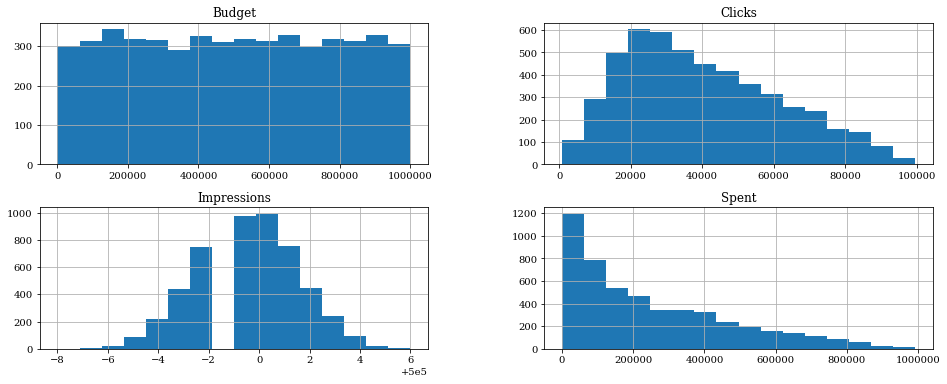

In [38]:
df[['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=16, figsize=(16, 6));

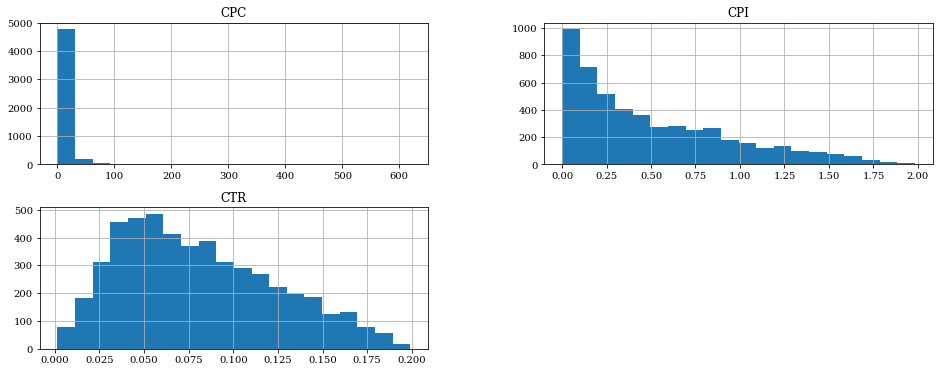

In [39]:
df[['CTR', 'CPC', 'CPI']].hist(
    bins=20, figsize=(16, 6));

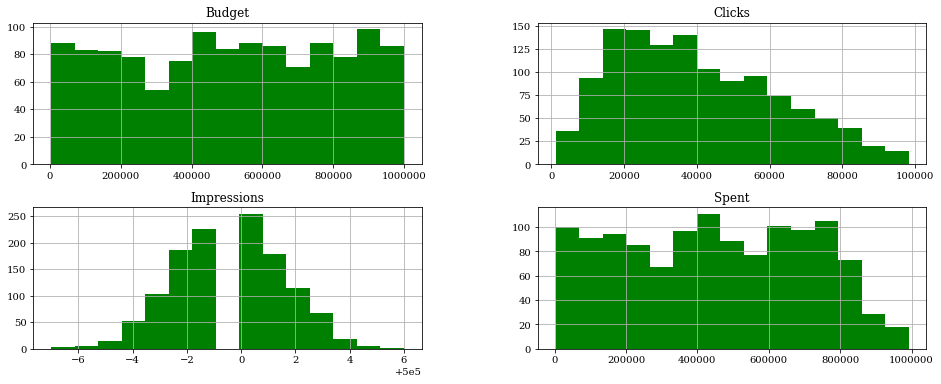

In [40]:
# let's see the campaigns whose spent is > than 75% of the budget
mask = (df.Spent > 0.75 * df.Budget)
df[mask][['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=15, figsize=(16, 6), color='g');

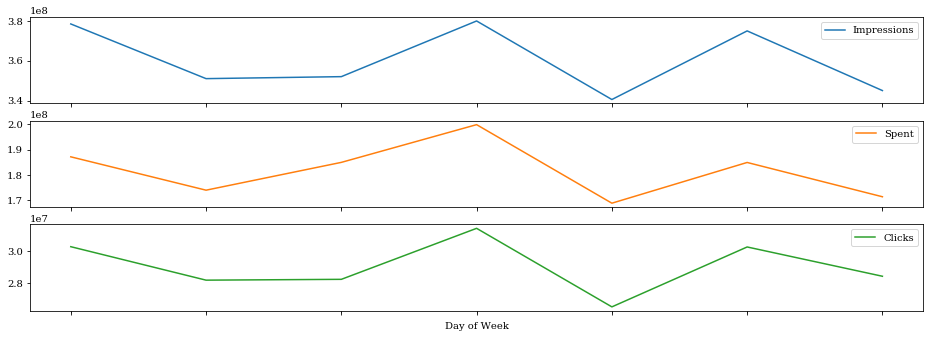

In [41]:
# Let's aggregate per Day of the Week
df_weekday = df.groupby(['Day of Week']).sum()
df_weekday[['Impressions', 'Spent', 'Clicks']].plot(
    figsize=(16, 6), subplots=True);

In [42]:
# Let's aggregate per gender
agg_config = {
    'Impressions': {
        'Mean Impr': 'mean',
        'Std Impr': 'std',
    },
    'Spent': ['mean', 'std'],
}

df.groupby(['Target Gender', 'Target Age']).agg(agg_config)

C:\Users\maria\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Impressions                    Spent  \
                              Mean Impr  Std Impr           mean   
Target Gender Target Age                                           
B             20-25       499999.986842  1.858267  264042.789474   
              20-30       499999.600000  2.016389  254606.162500   
              20-35       499999.354430  2.130595  278058.658228   
              20-40       499999.384615  1.558167  275816.061538   
              20-45       499999.411765  2.237712  150431.352941   
              25-30       499999.437500  2.042856  275036.225000   
              25-35       499999.293333  1.666631  232301.826667   
              25-40       499999.905405  1.866569  303749.716216   
              25-45       499999.333333  2.305649  251787.871795   
              25-50       499999.500000  2.202939  161377.833333   
              30-35       499999.500000  2.206633  235314.590909   
              30-40       499999.345238  2.079701  258632.083333   
              30-45       499999.402439  2.119048  201157.890244   
              30-50       499999.301205  2.004476  236948.156627   
              30-55       499999.636364  1.566699  207958.090909   
              35-40       499999.589041  2.040123  280335.547945   
              35-45       499999.313253  1.840783  235842.771084   
              35-50       499999.437500  1.675163  292897.637500   
              35-55       499999.756098  2.046140  207964.524390   
              35-60       499998.937500  1.768945  344129.750000   
              40-45       499999.459016  2.029563  254728.163934   
              40-50       499999.390625  2.193911  230299.734375   
              40-55       499999.476923  2.107336  242041.876923   
              40-60       500000.121951  2.014701  291629.219512   
              40-65       500000.294118  1.794600  255541.117647   
              45-50       500000.600000  2.164651  374794.466667   
              45-55       500000.318182  2.398141  156223.954545   
              45-60       499999.600000  1.505545  275651.500000   
              45-65       499998.533333  1.552264  188813.666667   
              45-70       499999.666667  1.527525  131517.000000   
...                                 ...       ...            ...   
M             20-25       499998.925926  2.084333  247035.098765   
              20-30       500000.121622  1.901353  291738.554054   
              20-35       499999.867647  1.991807  262695.058824   
              20-40       499999.602740  1.984242  212553.630137   
              20-45       500000.176471  1.380004  261475.764706   
              25-30       499999.395349  1.960066  247791.825581   
              25-35       499999.152778  2.066907  262673.625000   
              25-40       499999.580247  2.024007  278667.382716   
              25-45       499999.046875  2.228457  299316.109375   
              25-50       499999.000000  1.369306  305065.823529   
              30-35       499999.333333  2.127205  287806.913580   
              30-40       499999.680000  1.973884  270356.186667   
              30-45       499999.253165  2.003000  239524.025316   
              30-50       499999.805195  1.967091  240052.545455   
              30-55       499998.642857  1.549548  306205.214286   
              35-40       499999.425287  1.997860  242578.080460   
              35-45       499999.803030  2.275080  238568.090909   
              35-50       499999.229730  1.996897  231278.500000   
              35-55       499999.253731  1.901700  202238.970149   
              35-60       499999.500000  1.743118  217008.928571   
              40-45       499999.702381  2.058071  236617.809524   
              40-50       499999.582418  1.838272  293646.637363   
              40-55       499999.597561  2.303297  256025.829268   
              40-60       499999.485294  2.084002  236582.867647   
              40-65       499999.645161  1.495513  289325.096774   
              45

In [43]:
# finally, let's make a pivot table
pivot = df.pivot_table(
    values=['Impressions', 'Clicks', 'Spent'],
    index=['Target Age'],
    columns=['Target Gender'],
    aggfunc=np.sum
)
pivot

Clicks                   Impressions                      \
Target Gender        B        F        M           B         F         M   
Target Age                                                                 
20-25          3006221  3050087  3263845    37999999  39499955  40499913   
20-30          3358209  2795755  2930920    39999968  35499976  37000009   
20-35          3336538  3634890  2400868    39499949  38999954  33999991   
20-40          2641838  2566120  3129000    32499960  31999965  36499971   
20-45           743386  1036700   562041     8499990  11999993   8500003   
25-30          3261966  2711211  3233009    39999955  32999974  42999948   
25-35          2978614  3278198  2854494    37499947  38499981  35999939   
25-40          2911606  3195576  3189991    36999993  41499959  40499966   
25-45          3173073  2738570  2722136    38999948  32499977  31999939   
25-50           458565   849559   461209     8999991   9499986   8499983   
30-35          2696592  2931506  3070173    32999967  34999984  40499946   
30-40          3647734  2981039  2998128    41999945  35999960  37499976   
30-45          3230175  3489209  3384505    40999951  42499968  39499941   
30-50          3220096  3543989  2903312    41499942  40499972  38499985   
30-55           423957   613139   419276     5499996   8000000   6999981   
35-40          3125287  3365979  3262950    36499970  41999930  43499950   
35-45          3501580  3022143  2410387    41499943  34499959  32999987   
35-50          3616626  2972822  2905108    39999955  37999957  36999943   
35-55          3256257  2800691  2694213    40999980  32999978  33499950   
35-60           546961   656815   579139     7999983   6999980   6999993   
40-45          2204303  3900650  3260722    30499967  43499949  41999975   
40-50          2798036  3815029  3616218    31999961  48499942  45499962   
40-55          2307872  3346925  2964343    32499966  38999970  40999967   
40-60          3366409  3933615  2362047    41000010  44499945  33999965   
40-65           660399   754755  1135855     8500005   9499993  15499989   
45-50           549862   950306   808532     7500009  12499989   8999980   
45-55           991152   457104   612194    11000007   5999982   7999985   
45-60           391087   698247   402605     4999996   8000001   3999991   
45-65           482412   601775   797486     7499978   7499996   9500004   
45-70           182008   230475    54763     1499999   2999996    500002   

                  Spent                      
Target Gender         B         F         M  
Target Age                                   
20-25          20067252  17385058  20009843  
20-30          20368493  16919283  21588653  
20-35          21966634  18760260  17863264  
20-40          17928044  18240185  15516415  
20-45           2557333   6112215   4445088  
25-30          22002898  17310724  21310097  
25-35          17422637  20766991  18912501  
25-40          22477479  25793986  22572058  
25-45          19639454  16879431  19156231  
25-50           2904801   3582009   5186119  
30-35          15530763  16632663  23312360  
30-40          21725095  19614012  20276714  
30-45          16494947  22377322  18922398  
30-50          19666697  18327330  18484046  
30-55           2287539   3414143   4286873  
35-40          20464495  19393645  21104293  
35-45          19574950  16321305  15745494  
35-50          23431811  15909875  17114609  
35-55          17053091  14197399  13550011  
35-60           5506076   3304506   3038125  
40-45          15538418  22137599  19875896  
40-50          14739183  24043836  26721844  
40-55          15732722  22679671  20994118  
40-60          23913596  22748438  16087635  
40-65           4344199   4417146   8969078  
45-50           5621917   5012915   3296892  
45-55           3436927   2726736   4169681  
45-60           2756515   4706005   1205141  
45-65           2832205   3980608   4631383  
45-70            394551    947128  